In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import torch
import timm
from torch import nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class Config:
    DATA_PATH = "/kaggle/input/rsna-2022-cervical-spine-fracture-detection"
    TRAIN_IMG_PATH = os.path.join(DATA_PATH, "train_images")
    TRAIN_CSV = os.path.join(DATA_PATH, "train.csv")
    BBOX_CSV = os.path.join(DATA_PATH, "train_bounding_boxes.csv")
    SEGMENTATION_PATH = os.path.join(DATA_PATH, "segmentations")
    BATCH_SIZE = 8
    NUM_EPOCHS = 10
    LEARNING_RATE = 5e-5
    NUM_WORKERS = 4
    IMG_SIZE = 224
    VERTEBRAE_LABELS = ['C1','C2','C3','C4','C5','C6','C7']
    NUM_CLASSES = len(VERTEBRAE_LABELS)
    DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    VAL_SPLIT = 0.3
    RANDOM_STATE = 42
config = Config()

class CervicalSliceDataset(Dataset):
    def __init__(self, samples_df, img_path, transforms=None):
        self.samples_df = samples_df.reset_index(drop=True)
        self.img_path = img_path
        self.transforms = transforms
    def __len__(self):
        return len(self.samples_df)
    def _load_dicom_slice(self, study_id, slice_number):
        study_path = os.path.join(self.img_path, study_id)
        if not os.path.exists(study_path):
            return None
        dicom_file = f"{int(slice_number)}.dcm"
        dicom_path = os.path.join(study_path, dicom_file)
        if not os.path.exists(dicom_path):
            all_files = sorted([f for f in os.listdir(study_path) if f.endswith('.dcm')])
            if not all_files:
                return None
            slice_nums = [int(f.replace('.dcm','')) for f in all_files]
            closest_idx = int(np.argmin([abs(s - slice_number) for s in slice_nums]))
            dicom_path = os.path.join(study_path, all_files[closest_idx])
        try:
            ds = pydicom.dcmread(dicom_path)
            img = ds.pixel_array.astype(np.float32)
            if hasattr(ds, 'RescaleIntercept') and hasattr(ds, 'RescaleSlope'):
                img = img * ds.RescaleSlope + ds.RescaleIntercept
            img = np.clip(img, -1000, 2000)
            img = (img - img.min()) / (img.max() - img.min() + 1e-6) * 255.0
            img = img.astype(np.uint8)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            return img
        except Exception:
            return None
    def __getitem__(self, idx):
        row = self.samples_df.iloc[idx]
        study_id = row['StudyInstanceUID']
        slice_number = row['slice_number']
        img = self._load_dicom_slice(study_id, slice_number)
        if img is None:
            rand_idx = np.random.randint(0, len(self))
            return self.__getitem__(rand_idx)
        labels = np.array([float(row.get(v, 0)) for v in config.VERTEBRAE_LABELS], dtype=np.float32)
        if self.transforms:
            augmented = self.transforms(image=img)
            img = augmented['image']
        else:
            img = torch.from_numpy(img).permute(2,0,1).float() / 255.0
        if isinstance(img, torch.Tensor):
            img = img.float()
        return img, torch.from_numpy(labels)

def get_train_transforms():
    return A.Compose([
        A.Resize(config.IMG_SIZE, config.IMG_SIZE),
        A.HorizontalFlip(p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        ToTensorV2()
    ])

def get_valid_transforms():
    return A.Compose([
        A.Resize(config.IMG_SIZE, config.IMG_SIZE),
        ToTensorV2()
    ])

def build_deit_model(num_classes, pretrained=True):
    model = timm.create_model('deit_base_patch16_224', pretrained=pretrained)
    if hasattr(model, 'head'):
        in_feats = model.head.in_features
        model.head = nn.Linear(in_feats, num_classes)
    elif hasattr(model, 'classifier'):
        in_feats = model.classifier.in_features
        model.classifier = nn.Linear(in_feats, num_classes)
    return model

def collate_fn(batch):
    imgs = torch.stack([b[0] for b in batch])
    imgs = imgs.float()
    labels = torch.stack([b[1] for b in batch]).float()
    return imgs, labels

def train_one_epoch(model, loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    steps = 0
    for imgs, labels in loader:
        imgs = imgs.to(device, non_blocking=True).float()
        labels = labels.to(device, non_blocking=True).float()
        optimizer.zero_grad()
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        running_loss += loss.item()
        steps += 1
    return running_loss / max(1, steps)

@torch.no_grad()
def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    steps = 0
    all_preds = []
    all_targets = []
    for imgs, labels in loader:
        imgs = imgs.to(device, non_blocking=True).float()
        labels = labels.to(device, non_blocking=True).float()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        probs = torch.sigmoid(outputs).detach().cpu().numpy()
        all_preds.append(probs)
        all_targets.append(labels.detach().cpu().numpy())
        running_loss += loss.item()
        steps += 1
    if len(all_preds) == 0:
        return 0.0, np.zeros((0,config.NUM_CLASSES)), np.zeros((0,config.NUM_CLASSES))
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    return running_loss / max(1, steps), all_preds, all_targets

def threshold_preds(preds, thresh=0.5):
    return (preds >= thresh).astype(int)

_CONFUSION_POOL = []

def plot_confusion(cm, outpath, vertebra_name=None):
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['neg','pos'])
    ax.set_yticklabels(['neg','pos'])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(int(cm[i,j])), ha='center', va='center')
    if vertebra_name is not None:
        ax.set_title(vertebra_name)
    plt.savefig(outpath, bbox_inches='tight', dpi=150)
    plt.close()
    _CONFUSION_POOL.append((vertebra_name if vertebra_name is not None else outpath, cm.copy()))


def show_all_confusions(outpath='all_confusions.png'):
    if len(_CONFUSION_POOL) == 0:
        return
    n = len(_CONFUSION_POOL)
    cols = 4
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = np.array(axes).reshape(-1)
    for ax in axes[n:]:
        ax.axis('off')
    vmax = max(cm.max() for _, cm in _CONFUSION_POOL)
    for i, (name, cm) in enumerate(_CONFUSION_POOL):
        ax = axes[i]
        im = ax.imshow(cm, interpolation='nearest', vmin=0, vmax=vmax)
        ax.set_xticks([0,1])
        ax.set_yticks([0,1])
        ax.set_xticklabels(['neg','pos'])
        ax.set_yticklabels(['neg','pos'])
        for r in range(2):
            for c in range(2):
                ax.text(c, r, str(int(cm[r,c])), ha='center', va='center')
        ax.set_title(name)
    fig.colorbar(im, ax=axes[:n].tolist(), shrink=0.6, location='right')
    plt.tight_layout()
    plt.savefig(outpath, dpi=150, bbox_inches='tight')
    plt.show()

show_all_confusions()

def run_deit():
    train_df = pd.read_csv(config.TRAIN_CSV)
    bbox_df = pd.read_csv(config.BBOX_CSV)
    samples = []
    for _, row in bbox_df.iterrows():
        samples.append({'StudyInstanceUID': row['StudyInstanceUID'], 'slice_number': row['slice_number']})
    samples_df = pd.DataFrame(samples)
    samples_df = samples_df.merge(train_df, on='StudyInstanceUID', how='left')
    samples_df.fillna(0, inplace=True)
    train_idx, val_idx = train_test_split(samples_df.index.values, test_size=config.VAL_SPLIT, random_state=config.RANDOM_STATE, stratify=None)
    train_df_split = samples_df.loc[train_idx].reset_index(drop=True)
    val_df_split = samples_df.loc[val_idx].reset_index(drop=True)
    train_dataset = CervicalSliceDataset(train_df_split, config.TRAIN_IMG_PATH, transforms=get_train_transforms())
    val_dataset = CervicalSliceDataset(val_df_split, config.TRAIN_IMG_PATH, transforms=get_valid_transforms())
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)
    model = build_deit_model(config.NUM_CLASSES, pretrained=True)
    model = model.to(config.DEVICE)
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    best_val_loss = float('inf')
    best_state = None
    for epoch in range(config.NUM_EPOCHS):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, config.DEVICE, scaler)
        val_loss, val_preds, val_targets = validate_one_epoch(model, val_loader, criterion, config.DEVICE)
        if val_loss < best_val_loss and val_loss > 0:
            best_val_loss = val_loss
            if isinstance(model, nn.DataParallel):
                best_state = model.module.state_dict()
            else:
                best_state = model.state_dict()
            torch.save(best_state, 'deit_best_model.pkl')
        print(f"Epoch {epoch+1}/{config.NUM_EPOCHS} TrainLoss={train_loss:.4f} ValLoss={val_loss:.4f}")
    if best_state is None:
        if isinstance(model, nn.DataParallel):
            best_state = model.module.state_dict()
        else:
            best_state = model.state_dict()
        torch.save(best_state, 'deit_best_model.pkl')
    if val_preds.size == 0:
        return
    val_preds_thr = threshold_preds(val_preds, 0.5)
    for i, v in enumerate(config.VERTEBRAE_LABELS):
        y_true = val_targets[:, i].astype(int)
        y_pred = val_preds_thr[:, i].astype(int)
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        outname = f'confusion_{v}.png'
        plot_confusion(cm, outname)
        report = classification_report(y_true, y_pred, digits=4, zero_division=0)
        print(f"Vertebra: {v}")
        print(report)
        print(f"Confusion matrix saved to {outname}")


run_deit()


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Epoch 1/10 TrainLoss=0.4442 ValLoss=0.2322
Epoch 2/10 TrainLoss=0.2196 ValLoss=0.1073
Epoch 3/10 TrainLoss=0.1489 ValLoss=0.0724
Epoch 4/10 TrainLoss=0.1149 ValLoss=0.0609
Epoch 5/10 TrainLoss=0.1002 ValLoss=0.0423
Epoch 6/10 TrainLoss=0.0839 ValLoss=0.0448
Epoch 7/10 TrainLoss=0.0719 ValLoss=0.0380
Epoch 8/10 TrainLoss=0.0615 ValLoss=0.0288
Epoch 9/10 TrainLoss=0.0490 ValLoss=0.0252
Epoch 10/10 TrainLoss=0.0469 ValLoss=0.0343
Vertebra: C1
              precision    recall  f1-score   support

           0     1.0000    0.9940    0.9970      1654
           1     0.9808    1.0000    0.9903       512

    accuracy                         0.9954      2166
   macro avg     0.9904    0.9970    0.9936      2166
weighted avg     0.9955    0.9954    0.9954      2166

Confusion matrix saved to confusion_C1.png
Vertebra: C2
              precision    recall  f1-score   support

           0     0.9816    0.9985    0.9900      1334
           1     0.9975    0.9700    0.9835       832

    accur

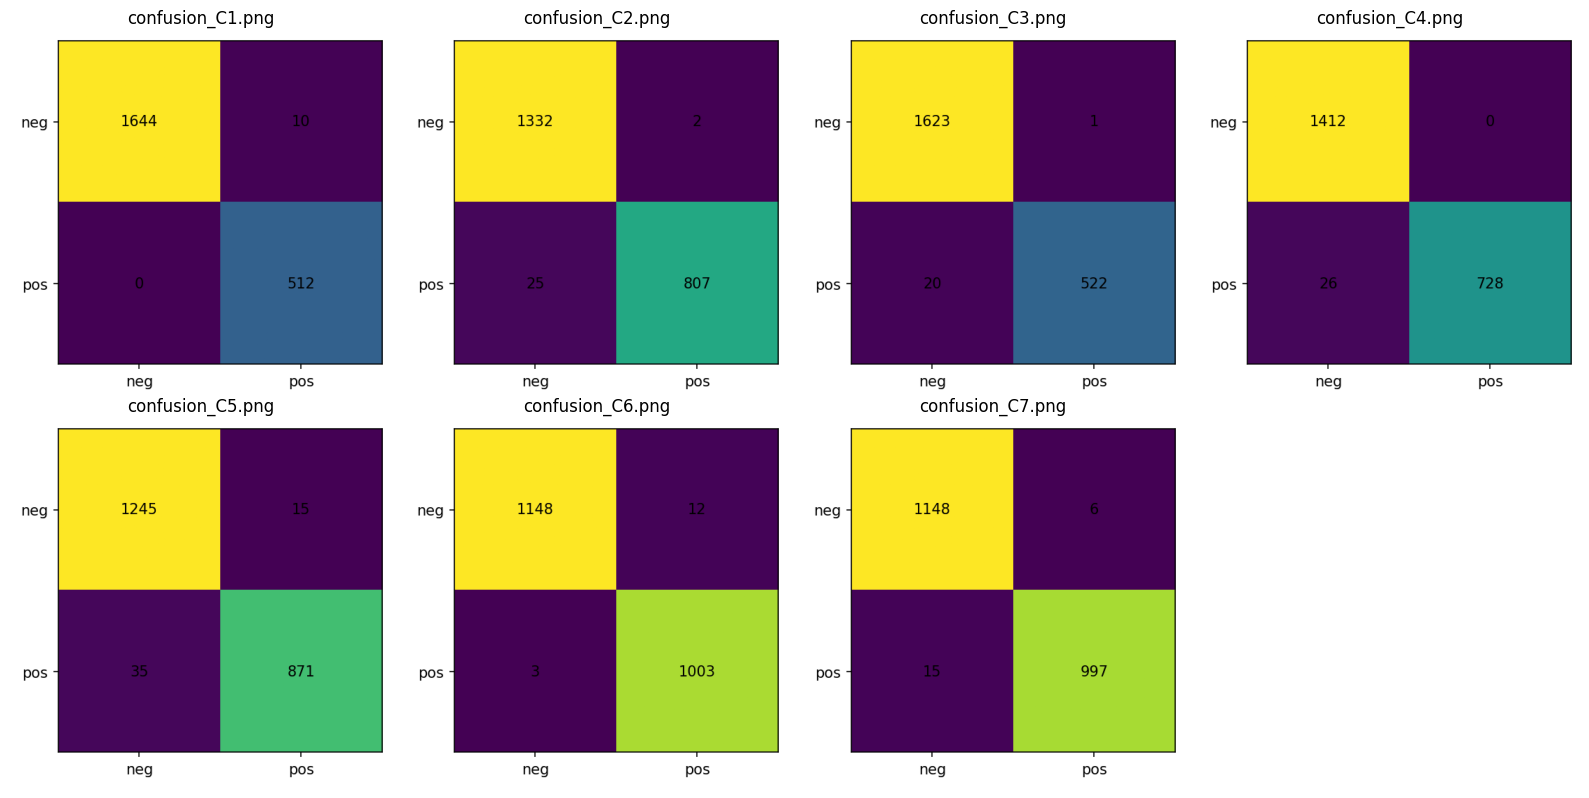

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
image_files = [
    'confusion_C1.png',
    'confusion_C2.png',
    'confusion_C3.png',
    'confusion_C4.png',
    'confusion_C5.png',
    'confusion_C6.png',
    'confusion_C7.png'
]

filas = 2
columnas = 4
fig, axes = plt.subplots(filas, columnas, figsize=(16, 8))

axes = axes.flatten()

for i, filename in enumerate(image_files):
    
    if os.path.exists(filename):
        img = mpimg.imread(filename)
        ax = axes[i]
        ax.imshow(img)
        ax.set_title(filename)
        ax.axis('off')
    else:
        print(f"Advertencia: El archivo '{filename}' no se encontró.")
        axes[i].axis('off') 

for j in range(len(image_files), len(axes)):
    axes[j].axis('off')

plt.tight_layout()

plt.show()